<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Unsupervised Learning: Clustering and K-Means
              
</p>
</div>

Data Science Cohort Live NYC Nov 2022
<p>Phase 4: Topic 33</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [1]:
from src.demo_images import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
sns.set_context('notebook')

## Learning Goals
- Assess what scenarios could use $k$-means
- Articulate the methodology used by $k$-means
- Apply KMeans from sklearn.cluster to a relevant dataset
- Select the appropriate number of clusters using the elbow method and Silhouette Scores
- Evaluate the weaknesses and remedies to $k$-means

#### Unsupervised Learning

Often don't have labels on data:

- Discover the structure in the data.
- Is there some kind of grouping in the data?
- Maybe discover relationship between subsets of the data 
- Its true dimensionality, etc.

Goals are much less clear here:
- We are not creating a prediction machine.
- Instead we are recognizing patterns and uncovering relationships.

#### Examples with clustering

There are no training labels here. Just data points:
    
- Our eyes can make out regions.
- But we want a computer to do this automatically.

In [2]:
import pandas as pd
X = pd.read_csv('Data/s1cluster.txt', delimiter = '\s+ ', header = None, names = ['X1', 'X2'], engine = 'python')
X.head()

,X1,X2
0,664159,550946
1,665845,557965
2,597173,575538
3,618600,551446
4,635690,608046


<AxesSubplot:xlabel='X1', ylabel='X2'>

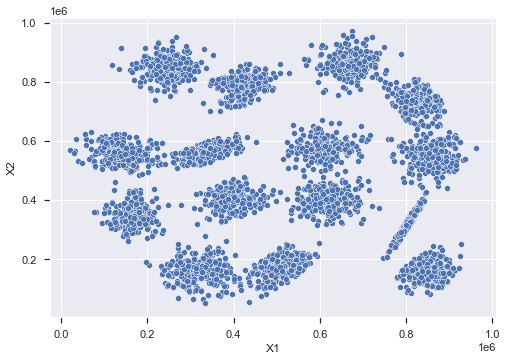

In [3]:
sns.scatterplot(x = 'X1', y = 'X2', data = X)

One example of some value:
- recognizing/labeling and segmenting different types of cell tissue.

<img src = "Images/clustercells.png" width = 600 />

- Discretize image.
- Clustering grid-cell in color-value space of RGB image
- Discover regions of epithelial vs. non-epithelial cells.

Another example might be segmenting customers into groups:

<center><img src = "Images/initialscenario.png" width = 500/></center>

<center><img src = "Images/cust_seg.jpg" width = 500/></center>

Discovering different types of customers within purchase data:

- Could potentially segment into 4 groups?
- Obviously targeted ads/deals, etc.

#### So what do you do with clustering results?

Once clusters are identified:
- Can use discovered clusters as a feature in a predictive task.
- e.g., predict churn rate using customer cluster assignment.


- *How were target labels in classification made in the first place?*

- Discovered clusters becomes _**target labels**_:
- Original data features and cluster assignment as training data for classifier

#### Our first clustering algorithm: KMeans
- Assuming $K$ clusters
- Assuming cluster centers (or centroids).
- Assign each data points to each of the $K$ clusters
    - pick cluster whose centroid is closest to data point.

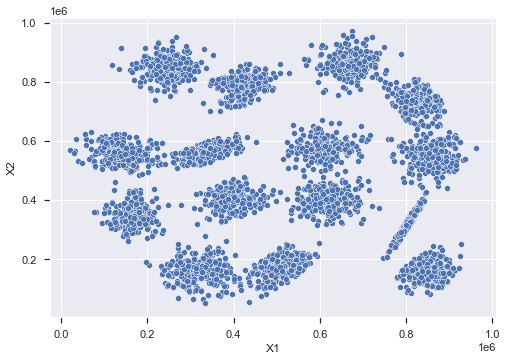

In [4]:
sns.scatterplot(x = 'X1', y = 'X2', data = X)
plt.show()

An iterative process:

- Dont know cluster centroids.
- Data points: don't know cluster assignments.

#### Can help use one to find the other

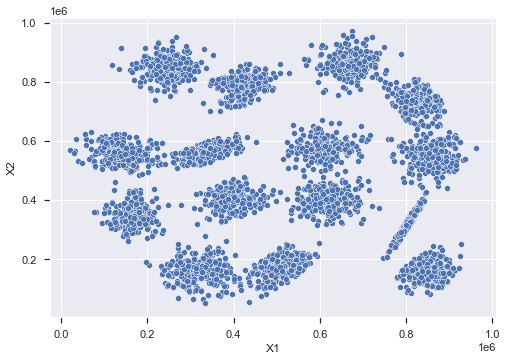

In [5]:
sns.scatterplot(x = 'X1', y = 'X2', data = X)
plt.show()

- Pick a random set of cluster center positions.
- Assign clusters to data points
- Data points and their cluster assignments:
    - get mean of data in each cluster
    - update centroid

<img src = "Images/kmeans.gif" />

It can be shown the procedure lowers the cost function:

$$L = \sum_{i=1}^N \sum_{k = 1}^K \mathbb{1}(c_i = k)|x_i - \mu_k|^2 $$

where $ \mathbb{1}(c_i = k) = 1$ if $x_i$ assigned to cluster $k$ else 0.

- Cost function known as **inertia**

<center>Kill iterations once convergence reached.</center>

<img src = "Images/kmeans_withobjective.gif" />

KMeans is a distanced based algorithm. 
- We need to scale first then do the clustering

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

Create a pipeline

In [7]:
steps = [('scaler', StandardScaler()), 
         ('kmc', KMeans(n_clusters = 15) ) ]
kmc_pipe = Pipeline(steps)

In [8]:
kmc_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('kmc', KMeans(n_clusters=15))])

**KMeans attributes**

- .cluster_centers_ attribute: fitted centroid locations
- .labels_ attribute: cluster assignments for each data point.

The centers are scaled:
- Need to unscale back to original data scale.

In [9]:
scld_centers = kmc_pipe['kmc'].cluster_centers_
kc_centers = kmc_pipe['scaler'].inverse_transform(scld_centers)

# class labels for each observation
class_assignment = kmc_pipe['kmc'].labels_

In [10]:
X['label'] = class_assignment
X.head()

,X1,X2,label
0,664159,550946,13
1,665845,557965,13
2,597173,575538,13
3,618600,551446,13
4,635690,608046,13


Visualize cluster assigment/visualization

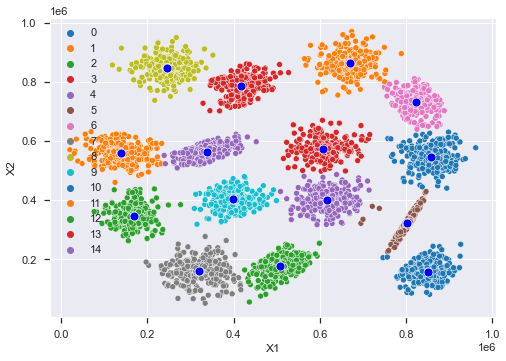

In [11]:
sns.set_palette("tab10")

sns.scatterplot(x = 'X1', y = 'X2', hue = 'label', palette=sns.color_palette('tab10', n_colors= 15), data = X)
sns.scatterplot(x = kc_centers[:,0], y = kc_centers[:,1], color = 'blue', s = 80)
#plt.legend([],[], frameon=False)

plt.show()

In [12]:
%%capture clusterplot 
sns.set_palette("tab10")

sns.scatterplot(x = 'X1', y = 'X2', hue = 'label', palette=sns.color_palette('tab10', n_colors= 15), data = X)
sns.scatterplot(x = kc_centers[:,0], y = kc_centers[:,1], color = 'blue', s = 80)
#plt.legend([],[], frameon=False)

plt.show()

Class assignment for a given test point:
- .predict() method for KMeans

In [13]:
kmc_pipe.predict([[0.5e6 , 0.8e6]])

array([3], dtype=int32)

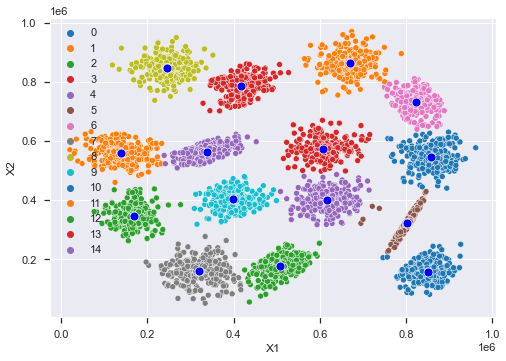

In [14]:
clusterplot()

#### Elbow method: choosing the appropriate number of $k$

KMeans inertia: can also get final value of loss function at convergence.
- This is important: can help us use as a diagnostic tool. 
- Help us pick $k$.

$$L = \sum_{i=1}^N \sum_{k = 1}^K \mathbb{1}(c_i = k)|x_i - \mu_k|^2 $$

In [15]:
kmc_pipe['kmc'].inertia_

154.60944586495623

Issue:
- Adding more and more centroids (increasing K)
- Arbitrarily decreases the convergence value of the inertia.
- More centroids: much lower squared distance of a point to *some* centroid.

$$L = \sum_{i=1}^N \sum_{k = 1}^K \mathbb{1}(c_i = k)|x_i - \mu_k|^2 $$

Define inertia vs K plotting function:

In [16]:
def plot_inertias(X, K, increment, kmc_pipe):

    klist = np.arange(1,K,increment)
    inertia_list = []
    for k in klist:
        kmc_pipe.steps.pop(-1)
        kmc_pipe.steps.append(('kmc', 
                               KMeans(
                                   n_clusters = k)))
        kmc_pipe.fit(X)

        inertia = kmc_pipe['kmc'].inertia_
        inertia_list.append(inertia)
        
    plt.plot(klist, inertia_list)
    plt.ylabel('Final inertia')
    plt.xlabel('K')
    plt.title('Elbow plot')
    plt.show()

Take in a very simple data set

In [17]:
X_simple = pd.read_csv('Data/xclara.txt').drop(columns = ['Unnamed: 0'])
X_simple.head()

,V1,V2
0,2.072345,-3.241693
1,17.936710,15.784810
2,1.083576,7.319176
3,11.120670,14.406780
4,23.711550,2.557729


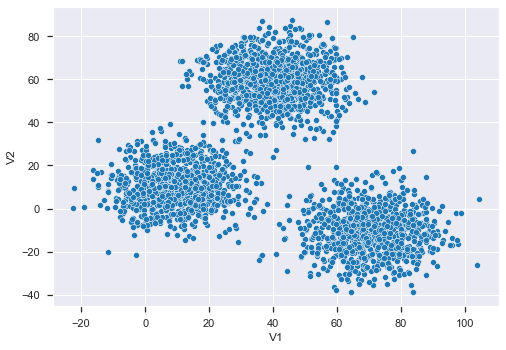

In [18]:
sns.scatterplot(x = 'V1', y = 'V2', data = X_simple)
plt.show()

Optimal cluster number at/near elbow/kink

Inertia decreases sharply until it hits optimal cluster number:
- Then increasing number makes marginal gains.

The behavior of inertia as a function of K is almost never this clean:
- well separated clusters
- similar sizes, etc

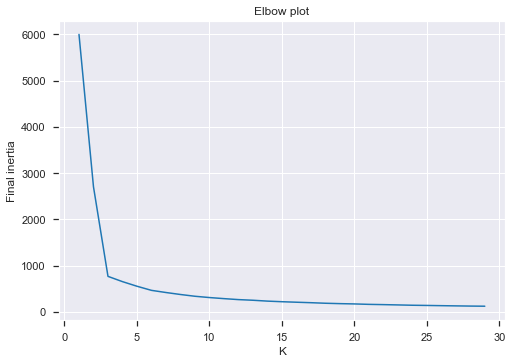

In [19]:
plot_inertias(X_simple, 30, 1, kmc_pipe)

Example with our old dataset: a little less good.

A good choice might be k = 15 (whis the real cluster number)

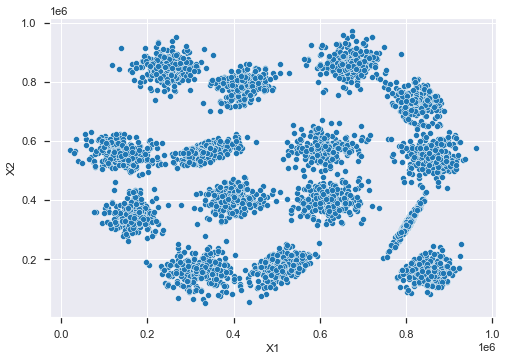

In [20]:
sns.scatterplot(x = 'X1', y = 'X2', data = X)
plt.show()

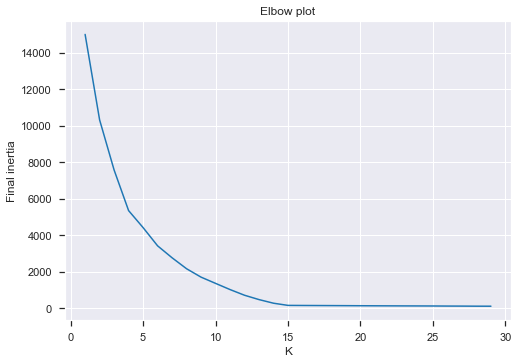

In [21]:
plot_inertias(X, 30, 1, kmc_pipe)

In [22]:
import pandas as pd
X_s4 = pd.read_csv('Data/s4cluster.txt', delimiter = '\s+ ', header = None, names = ['X1', 'X2'], engine = 'python')
X_s4.head()

,X1,X2
0,624474,837604
1,673412,735362
2,647442,677000
3,532283,741384
4,646529,742844


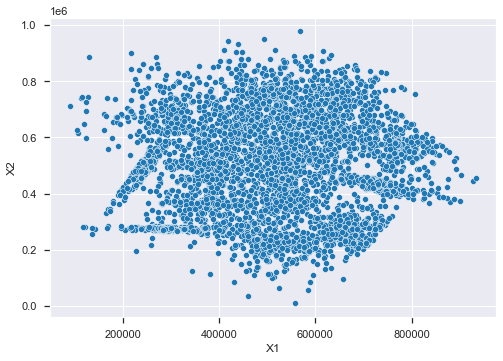

In [23]:
sns.scatterplot(x = 'X1', y = 'X2', data = X_s4)
plt.show()

Looks like a mess. But this kind of mess is typical.
- A hexbin density plot reveals the clustering structure.

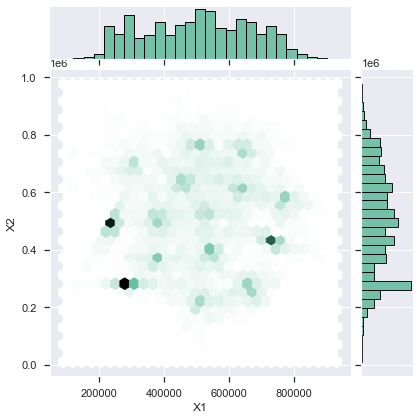

In [24]:
sns.jointplot(x= 'X1', y= 'X2', kind="hex", data = X_s4, color="#4CB391")
plt.show()

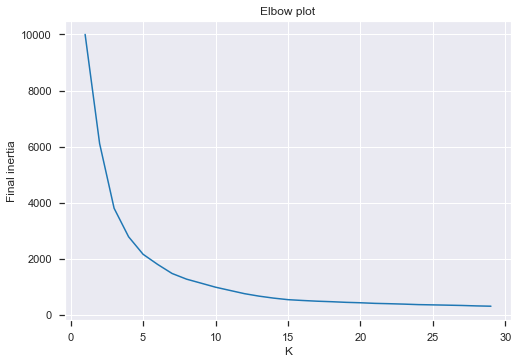

In [25]:
plot_inertias(X_s4, 30, 1, kmc_pipe)

Doesn't work very well.

- When there is a lot of overlap, sum of squared errors decreases smoothly with number of centroids.
- Need a better/more meaningful metric to measure effectiveness of clustering.

#### The silhouette coefficient
A more principled way of measuring clustering effectiveness

<img src = "Images/silhouette_distance.png"/>

The notion of **cohesion**: 
- how tightly bound is a point in a given cluster to its cluster members?

**Cohesiveness**

$$ a(i) = \overline{d(x_i, x_j)} $$ 

for $j$ indexing points in same clusters as point $i$.

**Average of distance of $i$ to its clustermates.**

The notion of **differentiation**: 
- how far away is a point in a given cluster from points in other clusters?

**Differentiation**

$$ b(i) = \overline{d(x_i, x_k)} $$ 

for $k$ indexing points in nearest neighboring cluster.

#### Silhouette index

Measuring binding of a point to its own cluster vs. neighboring cluster.

Silhouette index for point $i$:
$$ s(i) = \frac{b(i) - a(i)}{\max(a(i),b(i))} $$

- When $a(i)$ is very small compared to $b(i)$:
    - Point $i$ much more tightly bound to clustermates than neighboring cluster.
    - $s(i) \rightarrow 1$

- When $a(i)$ is very large compared to $b(i)$:
    - Point $i$ closer to points in neighboring cluster than its own.
    - $s(i) \rightarrow -1$

Visualizing silhouette index for entire dataset:
- cohesiveness/differentiation for each assigned cluster.

Let's evaluate clustering on our trickiest clustering dataset:

In [26]:
steps = [('scaler', StandardScaler()), 
         ('kmc', KMeans(n_clusters = 15) ) ]
kmc_pipe = Pipeline(steps)
X_s4['clstr_labels'] = kmc_pipe.fit_predict(X_s4[['X1', 'X2']])
X_s4.head()

,X1,X2,clstr_labels
0,624474,837604,1
1,673412,735362,1
2,647442,677000,14
3,532283,741384,11
4,646529,742844,1


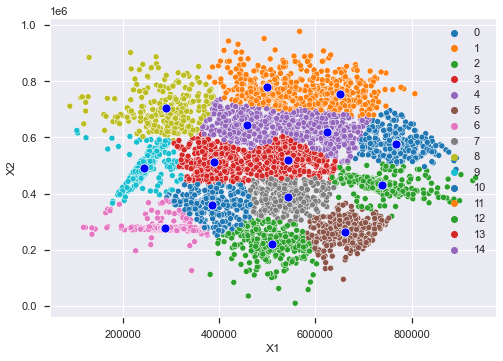

In [27]:
sns.set_palette("tab10")
scld_centers = kmc_pipe['kmc'].cluster_centers_
kc_centers = kmc_pipe['scaler'].inverse_transform(scld_centers)
sns.scatterplot(x = 'X1', y = 'X2', hue = 'clstr_labels', palette=sns.color_palette('tab10', n_colors= 15), data = X_s4)
sns.scatterplot(x = kc_centers[:,0], y = kc_centers[:,1], color = 'blue', s = 80)
#plt.legend([],[], frameon=False)

plt.show()

The fitted centroids and the centers of density line up well.

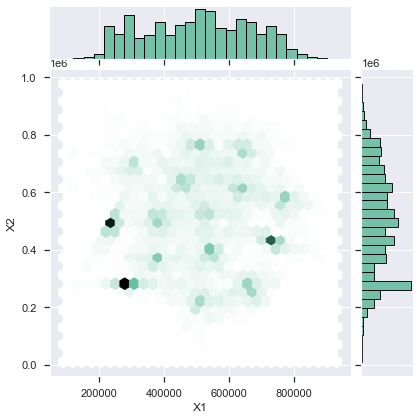

In [28]:
sns.jointplot(x= 'X1', y= 'X2', kind="hex", data = X_s4, color="#4CB391")
plt.show()

Scikit-learn can calculate silhouette index for each data point given cluster labels:

- silhouette_samples(data, cluster_labels)

In [29]:
from sklearn.metrics import silhouette_samples

Let'd do this on our clustering result:

In [30]:
silhouette_samples(X_s4[['X1', 'X2']],
                   X_s4['clstr_labels'])

array([0.3292536 , 0.56319425, 0.12100806, ..., 0.00372922, 0.47160577,
       0.47402238])

In [31]:
X_s4['silhouette'] = silhouette_samples(X_s4[['X1', 'X2']],
                   X_s4['clstr_labels'])

X_s4.head()

,X1,X2,clstr_labels,silhouette
0,624474,837604,1,0.329254
1,673412,735362,1,0.563194
2,647442,677000,14,0.121008
3,532283,741384,11,0.456216
4,646529,742844,1,0.617086


One useful plot is a barplot of the average silhouette index for each cluster.

In [32]:
col_list = ['clstr_labels', 'silhouette']
silh_idx_avgs = X_s4[col_list].groupby('clstr_labels').mean() #.sort_values(by = 'silhouette')

In [33]:
silh_idx_avgs.head()

,silhouette
clstr_labels,
0,0.376945
1,0.445364
2,0.590764
3,0.438266
4,0.439055


A visual of the cohesion/differentiation by cluster

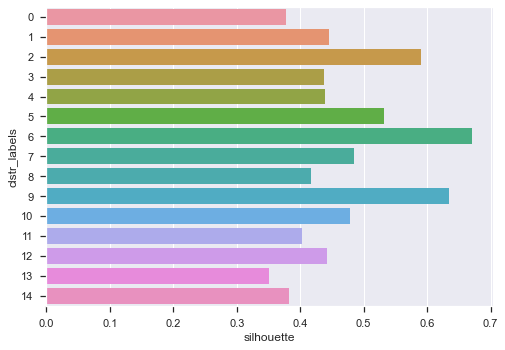

In [34]:
sns.barplot(x = 'silhouette', 
            y = 'clstr_labels', orient = 'h',
            data = silh_idx_avgs.reset_index())
plt.show()

**The silhouette score**: average silhouette index over all samples
- the better the clustering solution, the higher the value.

In [35]:
from sklearn.metrics import silhouette_score


In [36]:
s_score = silhouette_score(X_s4[['X1', 'X2']], X_s4['clstr_labels'])
s_score

0.4797327690812848

An often used visual is the silhouette plot.
- More information than average silhouette score by cluster.
- Distribution of silhouette indices by cluster.

In [37]:
def silhouette_plot(Xclustered_scores):
    
    n_clusters = 15
    
    fig, ax = plt.subplots(figsize = (8,11))
    
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax.axvline(x=s_score, color="red", linestyle="--")


    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = Xclustered_scores[Xclustered_scores['clstr_labels'] == i].silhouette

        ith_cluster_silhouette_values = ith_cluster_silhouette_values.sort_values(ascending = True)

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")


    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.show()
    

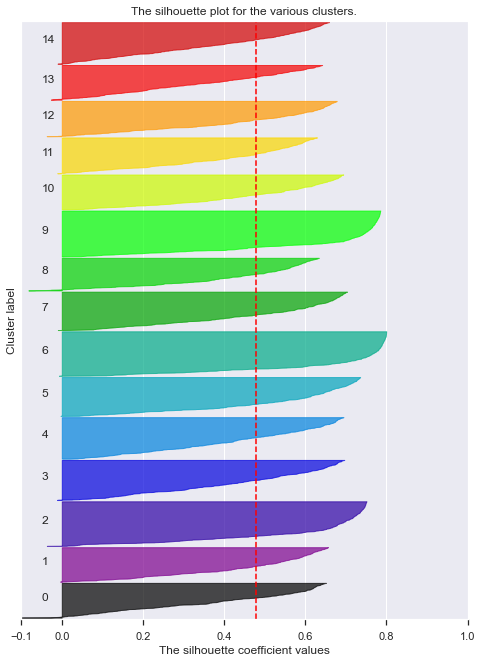

In [38]:
silhouette_plot(X_s4)

- Distribution of silhouette indices grouped by cluster.
- Want all labels to be above the average

Comparing plot by plot for each realization of $k$:
- comprehensive but also may want a quick/dirty metric for tuning K

#### Plotting silhouette coefficient vs. K
- Plot/metric for finding a plausible K

In [39]:
def plot_silh_scores(X, K, increment, kmc_pipe):

    klist = np.arange(2,K,increment)
    score_list = []
    for k in klist:
        kmc_pipe.steps.pop(-1)
        kmc_pipe.steps.append(('kmc', 
                               KMeans(
                                   n_clusters = k)))
        clstr_labels = kmc_pipe.fit_predict(X)

        score = silhouette_score(X, clstr_labels)
        score_list.append(score)
        
    sns.lineplot(x = klist, y = score_list, color = 'r')
    plt.ylabel('Silhouette Coefficient')
    plt.xlabel('K')
    plt.title('Silhouette coefficient plot')
    plt.show()

The maximum silhouette score is clearly at k = 15:
- matches our exact cluster number even with our trickier dataset.
- elbow plot tells us nothing.

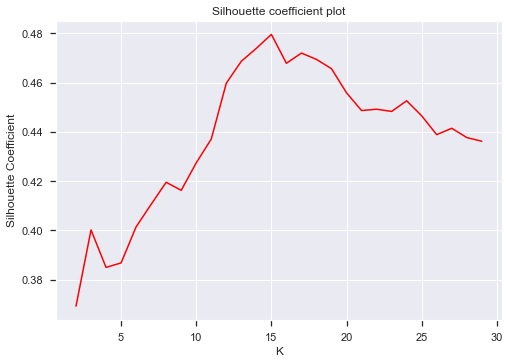

In [40]:
plot_silh_scores(X_s4[['X1', 'X2']], 
                 30, 1, kmc_pipe)

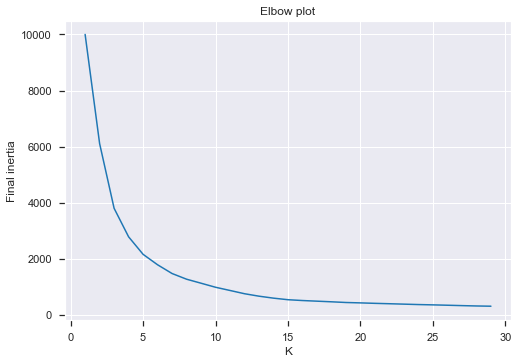

In [41]:
plot_inertias(X_s4[['X1', 'X2']], 
              30, 1, kmc_pipe)

#### **Limitations** of $k$-means

#### Ideal $k$-means scenario

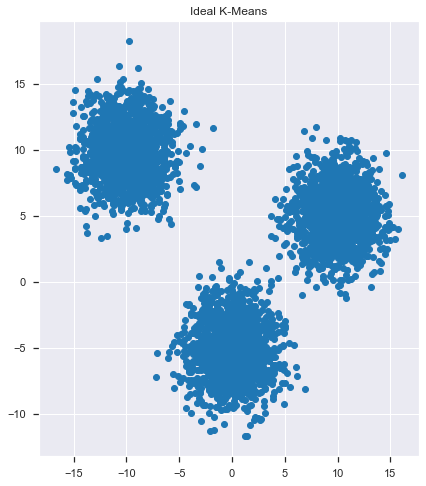

In [42]:
ideal()

#### KMeans works well when:

- Balanced cluster sizes
- Clusters have similar density
- Spherical clusters/equal variance of variables


#### Problem Scenario 1 - classes not all round

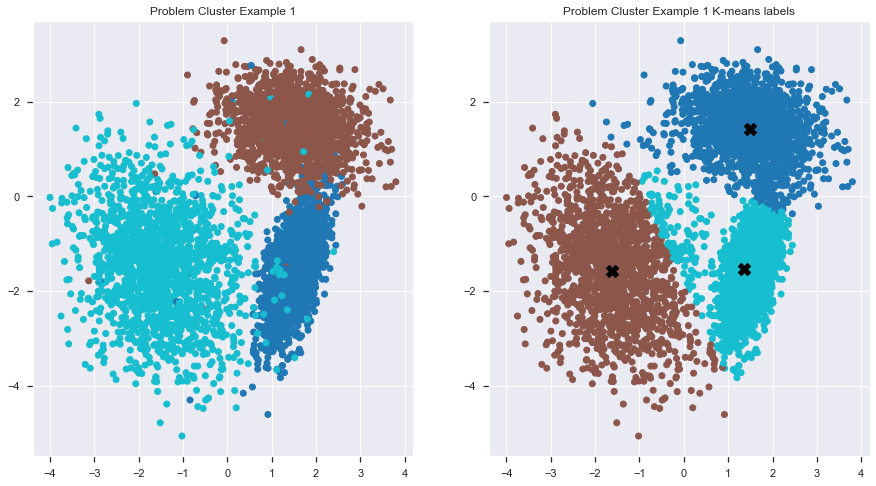

In [43]:
messyOne()

#### Problem Scenario 2 - imbalanced class size

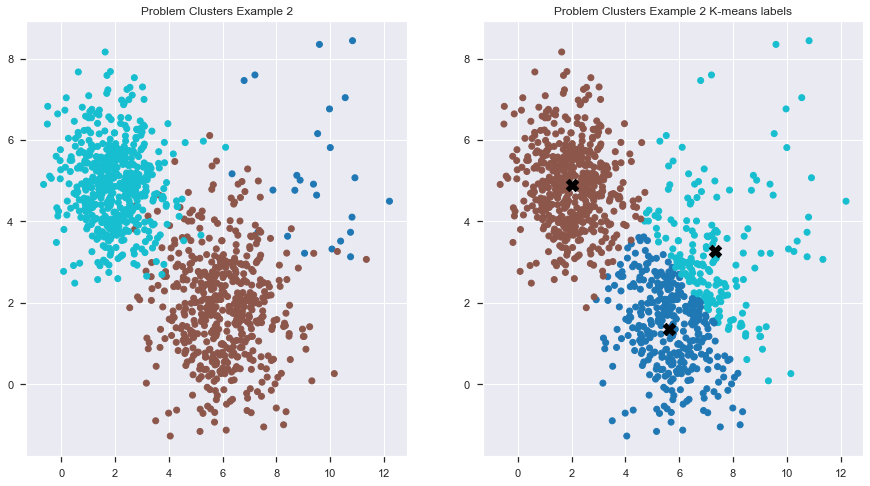

In [44]:
messyTwo()

#### Problem Scenario 3 - class size and density

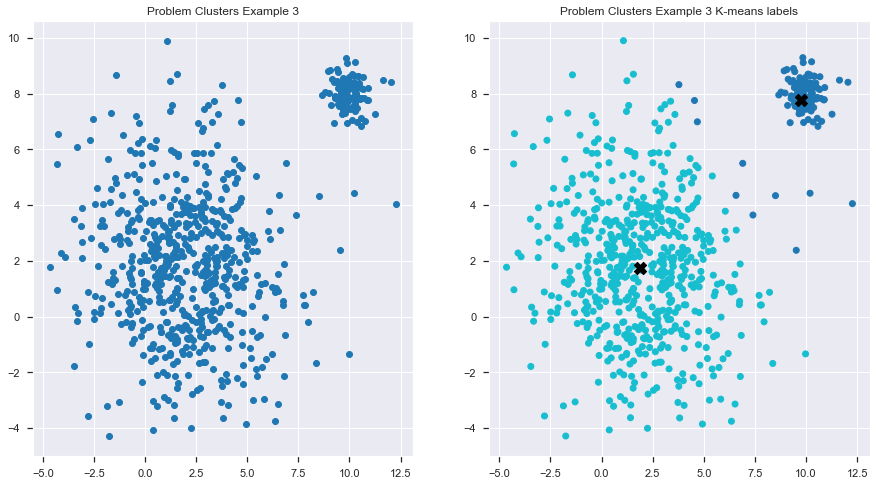

In [45]:
messyThree()

#### Solution to challenges:

- Try different clustering methods:
- e.g., Gaussian mixtures, DBSCAN, Hierarchical clustering, etc.

### $k$-means on larger dataset - Wine subscription

You want to run a wine subscription service, but you have no idea about wine tasting notes. You are a person of science.
You have a wine dataset of scientific measurements.
If you know a customer likes a certain wine in the dataset, can you recommend other wines to the customer in the same cluster?

#### Questions:
- How many clusters are in the wine dataset?
- What are the characteristics of each clusters?
- What problems do you see potentially in the data?

the dataset is `Wine.csv`

Instructions:
- First, remove customer_segment from the dataset

In [46]:
# Work on problem here: Would scaling make a difference?
wine = pd.read_csv('data/Wine.csv')
wine.drop(columns=['Customer_Segment'], inplace=True)
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The best number of clusters is 2


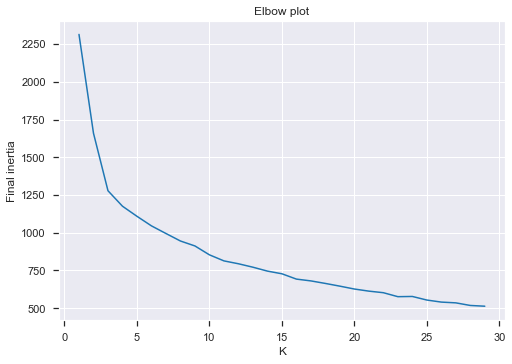

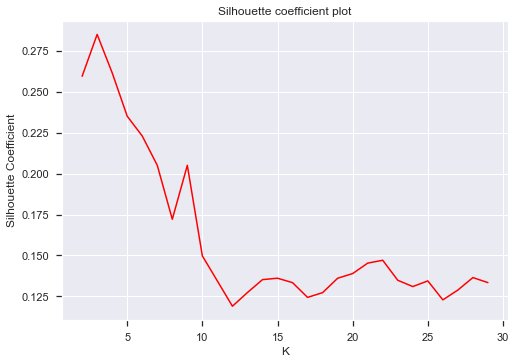

           Alcohol  Malic_Acid       Ash  Ash_Alcanity   Magnesium  \
cluster                                                              
0        12.702846    2.544553  2.339106     20.408130   96.813008   
1        13.666545    1.870727  2.427818     17.452727  106.290909   

         Total_Phenols  Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  \
cluster                                                                     
0             2.062114    1.641463              0.392683         1.454065   
1             2.816182    2.896545              0.292909         1.896909   

         Color_Intensity       Hue     OD280      Proline  
cluster                                                    
0               4.851382  0.908618  2.408211   565.869919  
1               5.520364  1.066655  3.066727  1151.727273  
[[1.27028455e+01 2.54455285e+00 2.33910569e+00 2.04081301e+01
  9.68130081e+01 2.06211382e+00 1.64146341e+00 3.92682927e-01
  1.45406504e+00 4.85138211e+00 9.08617886e-01

In [47]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(wine)
wine_scaled = ss.transform(wine)  

silhouette_scores = []

for j in range(2, 30):
    clusters = KMeans(n_clusters=j, random_state=42)
    cluster_labels = clusters.fit_predict(wine)
    silhouette = metrics.silhouette_score(wine, cluster_labels)
    silhouette_scores.append(silhouette)
print(f'The best number of clusters is {np.argmax(silhouette_scores) + 2}') 

plot_inertias(wine_scaled, 30, 1, kmc_pipe)

plot_silh_scores(wine_scaled, 30, 1, kmc_pipe)

best = KMeans(n_clusters=2, random_state=42)
wine['cluster'] = best.fit_predict(wine)

print(wine.groupby('cluster').mean())
print(best.cluster_centers_)

### Review $k$-means steps
1. Look at and clean data (if needed)
2. Scale data
3. Try various values of $k$
4. Plot SSE and Silhouette coefficient to find best $k$


### How many clusters fit the data?

What can you tell me about them?

<details>
    <summary>One answer here</summary>
    <code>from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(wine)
wine_scaled = ss.transform(wine)
silhouette_scores = []
for j in range(2, 30):
    clusters = KMeans(n_clusters=j, random_state=42)
    cluster_labels = clusters.fit_predict(wine)
    silhouette = metrics.silhouette_score(wine, cluster_labels)
    silhouette_scores.append(silhouette)
print(f'The best number of clusters is {np.argmax(silhouette_scores) + 2}') 
plot_inertias(wine_scaled, 30, 1, kmc_pipe)
plot_silh_scores(wine_scaled, 30, 1, kmc_pipe)
best = KMeans(n_clusters=2, random_state=42)
wine['cluster'] = best.fit_predict(wine)
print(wine.groupby('cluster').mean())
print(best.cluster_centers_)</code>
</details>